In [1]:
import numpy as np
import astropy.io.fits
import matplotlib.pyplot as plt
import scipy as sym 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import scipy.stats as stats
from astropy.stats import sigma_clip
c=const.c.to("km/s")
%matplotlib inline
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology on the basis of simulation

In [2]:
path_2_data = 'halodir_046_0000.fit'
print('opening', path_2_data)
my_file=astropy.io.fits.open(path_2_data)
print(my_file[1].data.columns)
data = my_file[1].data

opening halodir_046_0000.fit
ColDefs(
    name = 'M200c'; format = 'D'
    name = 'M500c'; format = 'D'
    name = 'Macc'; format = 'D'
    name = 'Mpeak'; format = 'D'
    name = 'Mpeak_Scale'; format = 'D'
    name = 'Mvir'; format = 'D'
    name = 'Mvir_all'; format = 'D'
    name = 'Rs_Klypin'; format = 'D'
    name = 'Rvir'; format = 'D'
    name = 'Spin'; format = 'D'
    name = 'Spin_Bullock'; format = 'D'
    name = 'T_U'; format = 'D'
    name = 'Vmax_Mpeak'; format = 'D'
    name = 'Voff'; format = 'D'
    name = 'Vpeak'; format = 'D'
    name = 'Xoff'; format = 'D'
    name = 'b_to_a'; format = 'D'
    name = 'b_to_a_500c'; format = 'D'
    name = 'c_to_a'; format = 'D'
    name = 'c_to_a_500c'; format = 'D'
    name = 'id'; format = 'K'
    name = 'pid'; format = 'K'
    name = 'rs'; format = 'D'
    name = 'scale_of_last_MM'; format = 'D'
    name = 'vmax'; format = 'D'
    name = 'vrms'; format = 'D'
    name = 'vx'; format = 'D'
    name = 'vy'; format = 'D'
    name = '

In [3]:
# Clusters ra , dec  and z
z   = data.field('redshift_R') # 
ra  = data.field('RA') #* (np.pi/180) # degrees
dec = data.field('DEC') # * (np.pi/180) # degrees
"R_cl the virial radius of the cluster"
r_cl= data.field('Rvir')[0]
r_cl

1059.21

In [4]:
z.min(),z.max()

(0.11636133626210864, 0.16483343927985872)

In [5]:
data.field('M200c').max()

105600000000000.0

In [6]:
#Applying the mask"mask =np.where(data.RA<42.50)

# Cluster ra and dec
z_cl=data.field('redshift_R')[0]

In [7]:
ra_cl=data.field('RA')[0]
dec_cl=data.field('DEC')[0]

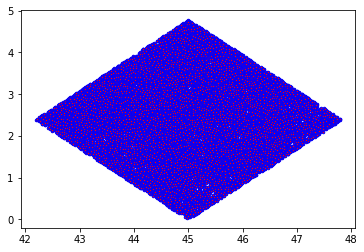

In [8]:

plt.plot(ra,dec,color='blue', linestyle='none', linewidth = 2, marker='.', markerfacecolor='red', markersize=5)

In [9]:
D_cl=cosmos.comoving_distance(z)
d_C = D_cl
dc_mpc = (d_C).value
dc_interpolation = interp1d(z, dc_mpc)
z_interpolation = interp1d(dc_mpc, z)
def get_x_y_z(ra_radian, dec_radian, rr):
    phi   = ( ra_radian   - 180 ) * np.pi / 180.
    theta = (dec_radian + 90 ) * np.pi / 180.
    xx = rr * np.cos( phi) * np.sin( theta )
    yy = rr * np.sin( phi) * np.sin( theta )
    zz = rr * np.cos( theta )
    return xx, yy, zz

# get 3D Cartesian positions of the sub haloes
xx, yy, zz = get_x_y_z(ra, dec, dc_interpolation(z))

#print('x mean, std',np.mean(data.field('x[mask]')-xx), np.std(data.field('x[mask]')-xx))
##print('x mean, std',np.mean(data.field('y')-yy), np.std(data.field('y')-yy))
#print('x mean, std',np.mean(data.field('z')-zz), np.std(data.field('z')-zz))

# get 3D Cartesian positions of the cluster
xx_cl, yy_cl, zz_cl = get_x_y_z(ra_cl, dec_cl, dc_interpolation(z_cl))
print('ra,dec,z=',ra_cl, dec_cl, z_cl, '\n x,y,z=',xx_cl, yy_cl, zz_cl)

# array of distances between sub haloes and the cluster : 
distances = np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 + (zz_cl-zz)**2)

ra,dec,z= 45.219549795736924 3.6196166616815617 0.16096834763192688 
 x,y,z= -481.5248587997155 -485.22935029602957 -43.243665674099454


In [10]:
distances.max()

186.8402956619868

In [11]:
mask= np.where(distances<1.05921)
len(ra[mask])

77

In [12]:
# From astropy inbuilt module separation
coordinates_SubHaloes = SkyCoord( ra[mask], dec[mask], unit='deg', frame='icrs') 
coordinate_cluster    = SkyCoord( ra_cl , dec_cl, unit='deg', frame='icrs') 
Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)

In [13]:
cc=Angular_separation_Astropy.radian

In [14]:
# Comoving distance
D = cosmos.comoving_distance(z_cl) 
print('the cluster at redshift ',z_cl,' is at dC=',D)
d_A=cosmos.angular_diameter_distance(z_cl)
d_A.value

the cluster at redshift  0.16096834763192688  is at dC= 684.9698728058967 Mpc


589.9987490641385

In [15]:
# Angular diameter distance
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl), 'per radian')
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl)/(180/np.pi), 'per degree')
print('Angular diameter distance at the clusters redshift :' , (cosmos.angular_diameter_distance(z_cl)/(180/np.pi)).to(u.kpc)/60, 'per arc minute    ')

Angular diameter distance at the clusters redshift : 589.9987490641385 Mpc per radian
Angular diameter distance at the clusters redshift : 10.297420753817029 Mpc per degree
Angular diameter distance at the clusters redshift : 171.6236792302838 kpc per arc minute    


In [16]:
# The angular separation between sub haloes and the cluster converted in Mpc
r_proj =  Angular_separation_Astropy_radian * cosmos.angular_diameter_distance(z_cl)/u.radian  # where D is comoving distance
print('min, max projected distance : ',r_proj.min(), r_proj.max(), 'compared to the 3D virial radius', r_cl/1000)

min, max projected distance :  0.0 Mpc 0.8868893811047515 Mpc compared to the 3D virial radius 1.05921


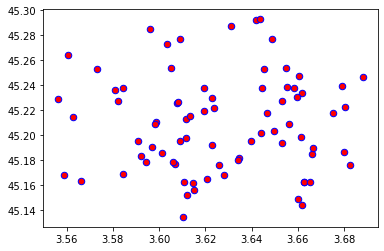

In [17]:

plt.plot(dec[mask],ra[mask],color='blue', linestyle='none', linewidth = 2, marker='.', markerfacecolor='red', markersize=13)

In [18]:
xx_cl,yy_cl,zz_cl

(-481.5248587997155, -485.22935029602957, -43.243665674099454)

In [19]:
r_cl/1000

1.05921

In [20]:
ra_cl,dec_cl,z_cl

(45.219549795736924, 3.6196166616815617, 0.16096834763192688)

/tmp/ipykernel_17549/116593402.py:18: RuntimeWarning: divide by zero encountered in power
  plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/1.51868, ls='')
/tmp/ipykernel_17549/116593402.py:18: RuntimeWarning: invalid value encountered in multiply
  plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/1.51868, ls='')


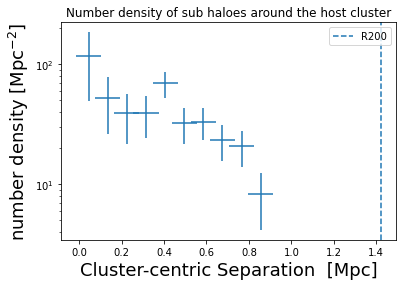

In [21]:
# create histogram of distances in Mpc

dR=0.09
r_bins = np.arange(0., 1.059,dR)
# Projected distance
N_2D, bins_2D = np.histogram(np.array(r_proj), bins = r_bins)
# Three D distance
N_3D, bins_3D = np.histogram(np.array(distances[mask]), bins = r_bins)

#Getting the number density profile in 2D 
n_2D = N_2D /(np.pi*( ( bins_2D[1:]**2 - bins_2D[:-1]**2) ) )

# central point of each separation 
R_2D = (bins_2D[1:] + bins_2D[:-1])/2.


#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/1.51868, ls='')
plt.yscale('log')
#plt.xscale('log')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
plt.axvline(x=1.42,linestyle='dashed',label = 'R200')
plt.legend(loc=1, numpoints=1)
plt.show()

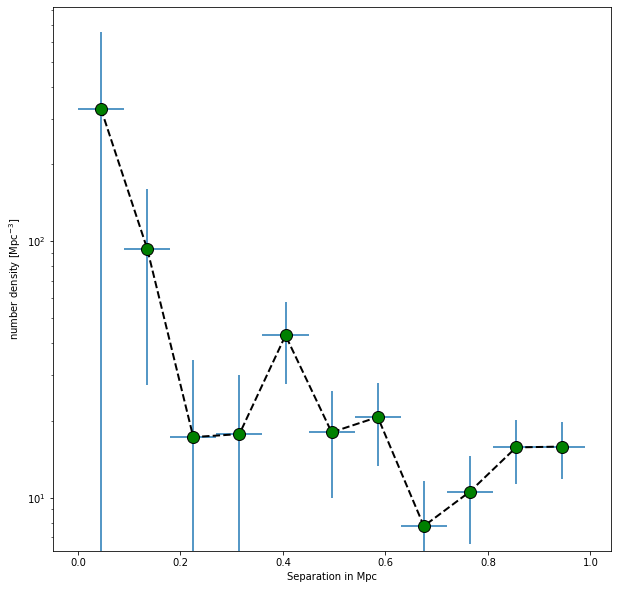

In [22]:
#Ns,rs=np.histogram(r)
number_density = N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))

r_act = (bins_3D[1:] + bins_3D[:-1])/2.
#plt.xscale('log')
#plt.yscale('log')
plt.figure(0, (10, 10))

plt.errorbar(r_act, number_density, xerr=dR/2., ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
plt.plot(r_act, number_density, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Separation in Mpc')
plt.ylabel(r'number density [Mpc$^{-3}$]')
plt.yscale('log')
plt.show()

In [23]:
r_array = np.arange(0., 1.04733504, 0.01)

In [24]:
"""
The interplation of dndR for solving the integral first of all 
Stacking the Proj and dndR

""" 
#Getting the derivative term of n wrt R_proj  ie dndR
dndR = np.array(np.gradient(n_2D,R_2D))
n_2D_no0 = N_2D
n_2D_no0[N_2D==0] = 1

dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_2D), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def nu(R_2D, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/np.pi)*(inter1(R_2D)/((R_2D**2 - r**2)**0.5))

    r_array = np.arange(0., 1.04733504, 0.01)
    nu_all=[integrate.quad(nu, r_i, 1.5, args=(r_i))[0] for r_i in r_array]
    return nu_all

nu_all = get_nu_all(dndR)
nu_all_up = get_nu_all(dndR_up)
nu_all_low = get_nu_all(dndR_low)



/tmp/ipykernel_17549/364573024.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all=[integrate.quad(nu, r_i, 1.5, args=(r_i))[0] for r_i in r_array]
/tmp/ipykernel_17549/364573024.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  nu_all=[integrate.quad(nu, r_i, 1.5, args=(r_i))[0] for r_i in r_array]
/tmp/ipykernel_17549/364573024.py:32: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  nu_all=[integrate.quad(nu, r_i, 1.5

/home/atul/anaconda3/lib/python3.9/site-packages/colossus/halo/profile_nfw.py:188: RuntimeWarning: divide by zero encountered in true_divide
  return rhos / x / (1.0 + x)**2
/home/atul/anaconda3/lib/python3.9/site-packages/colossus/halo/profile_nfw.py:188: RuntimeWarning: divide by zero encountered in true_divide
  return rhos / x / (1.0 + x)**2


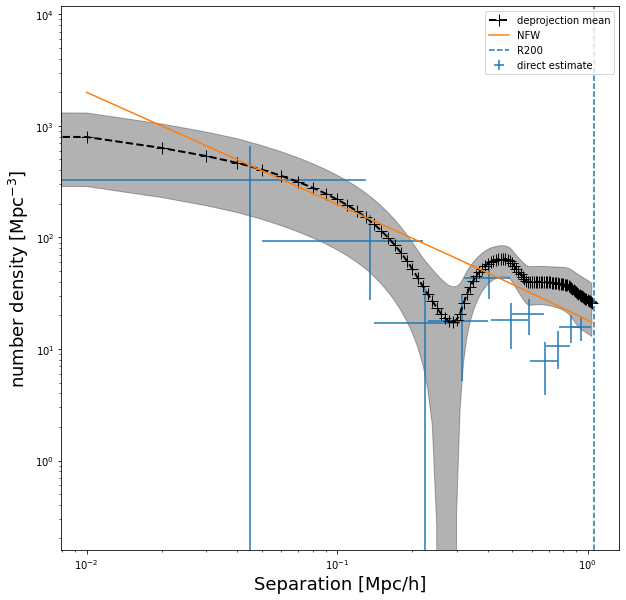

In [30]:
# plotting the de-projected number density wrt actual distance from the cluster center


# Nfw parameters modelling 
from colossus.halo import profile_nfw
# Parameters
Rs=20 
rhos = 1.0
# Nfw as function of actual radius of the cluster
p_nfw = profile_nfw.NFWProfile(rhos , Rs)

rho_nfw = p_nfw.density(r_array)
# Plotting the function 
plt.figure(0, (10, 10))

# Plotting  the de-projected number density
plt.plot(r_array, nu_all, label='deprojection mean', c='k',linestyle='dashed', linewidth = 2, marker='+', markerfacecolor='green', markersize=12)
plt.fill_between(r_array, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')

# Direct estimate error bars / Actual density
plt.errorbar(r_act, number_density, xerr=dR/1.059, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')

# Modelling with NFW
plt.plot(r_array,rho_nfw , label = 'NFW');
rho_nfw = p_nfw.density(r_array)
# axis
plt.xlabel('Separation [Mpc/h]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-3}$]',fontsize=18)

# r200
plt.axvline(x=1.059,linestyle='dashed',label = 'R200')

# Log scale
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=1, numpoints=1)

In [26]:
np.sort(c*z)

<Quantity [34884.25101418, 34884.54847278, 34884.64884227, ...,
           49415.35669327, 49415.52915793, 49415.8219223 ] km / s>

In [27]:
c*z_cl

<Quantity 48257.09659677 km / s>

In [28]:
(c*z)-c*z_cl

<Quantity [ 0.00000000e+00, -1.09855339e+01, -9.00217029e+00, ...,
           -8.42464487e+03, -5.92814949e+03, -1.24153241e+04] km / s>

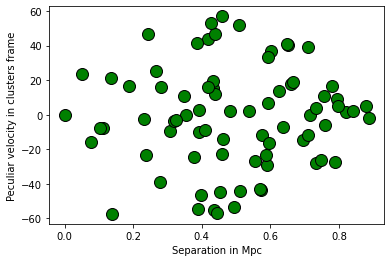

In [29]:
# Peculiar velocities of a members from there spectrosocpic
# redshift and mean redshift of a cluster

c=const.c.to("km/s")

los_v= c*(z[mask] -  z_cl)/(1 + z_cl)
los_v
plt.plot(r_proj,los_v, color='black', linestyle='none', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Separation in Mpc')
plt.ylabel('Peculiar velocity in clusters frame')
plt.show()